In [1]:
from utils.alloys import alloy_to_1d_tensor, make_params_df
from utils.constants import alloy_max_len, n_elements
from utils.ml import *
from utils.dataframes import dfs_tabs
from utils.rnn_predictor import LSTMClassifier, LSTMClassifierBidirectional, save_model_and_see_stats, save_predictions
from utils.ml import run_all_regressors, run_all_regressors_with_transformers
import torch
import matplotlib.pyplot as plt

2023-09-28 22:21:37.228611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 22:21:37.476904: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-28 22:21:38.378840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-09-28 22:21:38.379096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

In [2]:
df_train = pd.read_csv("train_final_df.csv")
df_test = pd.read_csv("test_final_df.csv")

print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)

Training set shape: (1269, 3)
Testing set shape: (318, 3)


In [3]:
# constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ideally a max factor is from the training dataset
max_factor = max(df_train["actual_d_max"])
print(max_factor)

35.0


In [4]:
# creating the input and output data for the model
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(df_train.shape[0]):
    X_train.append(alloy_to_1d_tensor(df_train.loc[i, "bmg_alloy"]))
    y_train.append(df_train.loc[i, "actual_d_max"] / max_factor)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

for i in range(df_test.shape[0]):
    X_test.append(alloy_to_1d_tensor(df_test.loc[i, "bmg_alloy"]))
    y_test.append(df_test.loc[i, "actual_d_max"] / max_factor)
    
# max_factor we selected is fine
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("X_train (shape and min-max):", X_train.shape, min(X_train.view(-1, 1)), max(X_train.view(-1, 1)),
      "y_train (shape and min-max):", y_train.shape, min(y_train.view(-1, 1)), max(y_train.view(-1, 1)))

print("X_test (shape and min-max):", X_test.shape, min(X_test.view(-1, 1)), max(X_test.view(-1, 1)),
      "y_test (shape and min-max):", y_test.shape, min(y_test.view(-1, 1)), max(y_test.view(-1, 1)))

X_train (shape and min-max): torch.Size([1269, 20]) tensor([0.]) tensor([98.9000]) y_train (shape and min-max): torch.Size([1269]) tensor([0.]) tensor([1.])
X_test (shape and min-max): torch.Size([318, 20]) tensor([0.]) tensor([97.5000]) y_test (shape and min-max): torch.Size([318]) tensor([0.]) tensor([0.8571])


In [5]:
# # Calculate mean and standard deviation from the training data along axis 0
# mean = torch.mean(X_train, dim=0)
# std = torch.std(X_train, dim=0)

# epsilon = 1e-8  # You can adjust this value if needed
# std = std + epsilon
# mean = mean + epsilon

# # Normalize the data
# normalized_X_train = (X_train - mean) / std
# normalized_X_test = (X_test - mean) / std

# un-normalized
X_train = torch.tensor(X_train, dtype=torch.float32) / 100
X_test = torch.tensor(X_test, dtype=torch.float32) / 100
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

print("X_train (shape and min-max):", X_train.shape, min(X_train.view(-1, 1)), max(X_train.view(-1, 1)),
      "y_train (shape and min-max):", y_train.shape, min(y_train.view(-1, 1)), max(y_train.view(-1, 1)))

print("X_test (shape and min-max):", X_test.shape, min(X_test.view(-1, 1)), max(X_test.view(-1, 1)),
      "y_test (shape and min-max):", y_test.shape, min(y_test.view(-1, 1)), max(y_test.view(-1, 1)))

X_train (shape and min-max): torch.Size([1269, 20]) tensor([0.]) tensor([0.9890]) y_train (shape and min-max): torch.Size([1269, 1]) tensor([0.]) tensor([1.])
X_test (shape and min-max): torch.Size([318, 20]) tensor([0.]) tensor([0.9750]) y_test (shape and min-max): torch.Size([318, 1]) tensor([0.]) tensor([0.8571])


In [6]:
input_size = 20
hidden_size = 128
learning_rate = 0.001
num_epochs = 0
batch_size = 32
num_layers = 4

model = LSTMClassifierBidirectional(input_size, hidden_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifierBidirectional(
  (lstm): LSTM(20, 128, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

# Create a PyTorch DataLoader for batching the data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
print_every = 100
plot_loss = []
# TODO: print the average loss
# EDIT: we are printing epoch loss of batch

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Iterate over the batches of data
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        # print("output", outputs.squeeze(), "\nlabel", labels)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    
    # Print the loss for this epoch
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    plot_loss.append(epoch_loss)

R2 Score: -6.5106


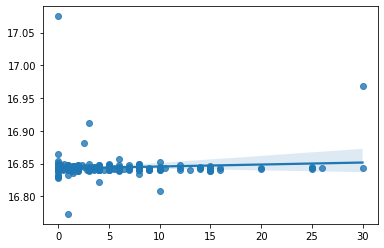

In [9]:
save_model_and_see_stats(model=model, model_file_name="rnn_method_1", 
                         X_test=X_test, y_test=y_test, max_factor=max_factor)

In [10]:
save_predictions(alloy_to_vectorized_tensor=alloy_to_1d_tensor, 
                 model=model, max_factor=max_factor, 
                 df_train=df_train, df_test=df_test, 
                 output_file_name="dataset_rnn_method_1")

In [11]:
df_train_with_params = make_params_df(df_train)
display(df_train_with_params)
df_test_with_params = make_params_df(df_test)
display(df_test_with_params)

,bmg_alloy,paper_sno,actual_d_max,rnn_encoding,h_mix,s_mix,delta_d,delta_e
0,B6.0Cr16.0Fe78.0,[9],0.00,17.01,17.04,0.66,0.03,0.05
1,B22.3Fe66.9Mo3.72Dy7.0,[9],2.00,17.00,22.50,0.91,0.13,-0.10
2,Mg11.0Ca55.0Cu23.0Zn11.0,"[5, 7]",1.00,17.00,9.47,1.15,0.37,-0.27
3,Mg84.5Mn8.0Y7.5,[9],0.00,17.00,9.26,0.54,0.17,0.03
4,Al95.0Co3.0Ce2.0,[9],0.00,17.00,10.76,0.23,0.22,-0.18
...,...,...,...,...,...,...,...,...
1264,Cu55.0Ga5.0Zr40.0,"[9, 5, 7]",2.00,17.00,15.88,0.85,0.25,-0.16
1265,B20.0Si4.0Fe71.2Cu0.8Nb4.0,[2],1.00,17.00,23.01,0.86,0.28,-0.01
1266,Mg25.0Ca55.0Zn20.0,"[9, 5, 7]",1.00,17.01,8.34,1.00,0.32,-0.19
1267,B6.0C15.0Cr4.0Mn10.0Fe53.0Mo12.0,[2],3.00,17.00,32.52,1.40,0.13,-0.16


,bmg_alloy,paper_sno,actual_d_max,rnn_encoding,h_mix,s_mix,delta_d,delta_e
0,Ni50.0Cu40.0Hf10.0,[9],0.00,17.01,16.39,0.94,0.28,-0.19
1,Al8.0Cu36.0Zr46.0Pd2.0Ag8.0,"[1, 6]",30.00,17.01,16.46,1.21,0.22,-0.15
2,Al25.0Co20.0Tm55.0,"[5, 7]",3.00,17.02,15.16,1.00,0.17,-0.16
3,B4.0C4.0Si2.0P10.0Fe75.0Ga3.0Mo2.0,"[1, 2, 5, 6, 9]",2.50,17.01,18.51,0.97,0.09,-0.11
4,Al2.0Cu90.0Ce8.0,[9],0.00,17.01,12.44,0.38,0.40,-0.26
...,...,...,...,...,...,...,...,...
313,B2.0Fe86.0Mo12.0,[9],0.00,17.01,17.19,0.46,0.02,-0.04
314,Fe42.0Cu41.0Ag17.0,[9],0.00,17.01,13.09,1.03,0.25,-0.01
315,Be23.0Ti24.0Fe6.0Ni10.0Cu9.0Zr28.0,"[1, 6]",4.00,17.00,15.92,1.65,0.19,-0.08
316,Mg22.5Ca50.0Cu27.5,"[9, 5, 7]",10.00,17.01,9.82,1.04,0.33,-0.24


In [12]:
X_train = df_train_with_params[['rnn_encoding', 'h_mix', 's_mix', 'delta_d', 'delta_e']]
y_train = df_train_with_params[['actual_d_max']]

X_test = df_test_with_params[['rnn_encoding', 'h_mix', 's_mix', 'delta_d', 'delta_e']]
y_test = df_test_with_params[['actual_d_max']]

In [13]:
run_all_regressors(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

 10%|████████                                                                            | 4/42 [00:00<00:02, 15.00it/s]

AdaBoostRegressor 0.1790965300215217
BaggingRegressor 0.6687093435766944
BayesianRidge 0.2958713895990719
DecisionTreeRegressor 0.44666147451388705
DummyRegressor -0.005335325313598593
ElasticNet 0.02651499774982069
ElasticNetCV 0.29414065231594144


 19%|████████████████                                                                    | 8/42 [00:00<00:01, 23.51it/s]

ExtraTreeRegressor 0.517730534040994
ExtraTreesRegressor 0.8008400113875657
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 26%|█████████████████████▋                                                             | 11/42 [00:01<00:04,  6.55it/s]

GaussianProcessRegressor -7009.759329768917
GradientBoostingRegressor 0.6082030355101474


 38%|███████████████████████████████▌                                                   | 16/42 [00:02<00:04,  6.11it/s]

HistGradientBoostingRegressor 0.6878296755843194
HuberRegressor 0.17784969180807497
KNeighborsRegressor 0.5148103053782749
KernelRidge 0.29580830893841736
Lars 0.29637004305918224


 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:02<00:01, 13.60it/s]

LarsCV 0.2961143757528705
Lasso -0.0015847624345575184
LassoCV 0.2963042873827413
LassoLars -0.0015847624345575184
LassoLarsCV 0.2961143757528705
LassoLarsIC 0.29637117568313
LinearRegression 0.29637004305918213
LinearSVR 0.18903694010488914


 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:04<00:02,  5.68it/s]

MLPRegressor 0.3482449688580913
NuSVR -0.03541994338310683
OrthogonalMatchingPursuit -0.0022477296188891938
OrthogonalMatchingPursuitCV 0.29503312434823914
PassiveAggressiveRegressor -0.16603559620996333


 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:04<00:01,  7.24it/s]

PoissonRegressor 0.11566153436367554
RANSACRegressor -0.03367765079718943


 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:04<00:01,  5.75it/s]

RandomForestRegressor 0.6982770046129017
Ridge 0.2958433491231468
RidgeCV 0.2958433491230751
SGDRegressor -888326994356.8547


 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:05<00:00,  6.91it/s]

SVR -0.1324577636472346
TransformedTargetRegressor 0.29637004305918213
TweedieRegressor 0.04210459139593581


 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:05<00:00,  6.01it/s]

XGBRegressor 0.7344245584416456
LGBMRegressor 0.7146722949003601
Learning rate set to 0.042513
0:	learn: 4.9037638	total: 52.8ms	remaining: 52.8s
1:	learn: 4.8343855	total: 54.8ms	remaining: 27.4s
2:	learn: 4.7610917	total: 56.5ms	remaining: 18.8s
3:	learn: 4.6960132	total: 58.2ms	remaining: 14.5s
4:	learn: 4.6292594	total: 59.8ms	remaining: 11.9s
5:	learn: 4.5714025	total: 62ms	remaining: 10.3s
6:	learn: 4.5135242	total: 71.2ms	remaining: 10.1s
7:	learn: 4.4668040	total: 73.2ms	remaining: 9.08s
8:	learn: 4.4139903	total: 75.7ms	remaining: 8.34s
9:	learn: 4.3646529	total: 77.6ms	remaining: 7.68s
10:	learn: 4.3150886	total: 79.8ms	remaining: 7.18s
11:	learn: 4.2635186	total: 82.5ms	remaining: 6.79s
12:	learn: 4.2180118	total: 86.1ms	remaining: 6.54s
13:	learn: 4.1743784	total: 89.2ms	remaining: 6.28s
14:	learn: 4.1359266	total: 91.5ms	remaining: 6.01s
15:	learn: 4.1055338	total: 93.1ms	remaining: 5.72s
16:	learn: 4.0731143	total: 94.6ms	remaining: 5.47s
17:	learn: 4.0363541	total: 100ms

205:	learn: 2.5682056	total: 473ms	remaining: 1.82s
206:	learn: 2.5617102	total: 475ms	remaining: 1.82s
207:	learn: 2.5600571	total: 477ms	remaining: 1.81s
208:	learn: 2.5573132	total: 478ms	remaining: 1.81s
209:	learn: 2.5528265	total: 481ms	remaining: 1.81s
210:	learn: 2.5497520	total: 483ms	remaining: 1.8s
211:	learn: 2.5464685	total: 485ms	remaining: 1.8s
212:	learn: 2.5445076	total: 486ms	remaining: 1.8s
213:	learn: 2.5419242	total: 488ms	remaining: 1.79s
214:	learn: 2.5350276	total: 490ms	remaining: 1.79s
215:	learn: 2.5333964	total: 491ms	remaining: 1.78s
216:	learn: 2.5293155	total: 493ms	remaining: 1.78s
217:	learn: 2.5265476	total: 495ms	remaining: 1.77s
218:	learn: 2.5236799	total: 497ms	remaining: 1.77s
219:	learn: 2.5207725	total: 498ms	remaining: 1.77s
220:	learn: 2.5178796	total: 500ms	remaining: 1.76s
221:	learn: 2.5159647	total: 502ms	remaining: 1.76s
222:	learn: 2.5140825	total: 503ms	remaining: 1.75s
223:	learn: 2.5116227	total: 505ms	remaining: 1.75s
224:	learn: 2.5

418:	learn: 1.9959753	total: 858ms	remaining: 1.19s
419:	learn: 1.9919215	total: 860ms	remaining: 1.19s
420:	learn: 1.9891724	total: 862ms	remaining: 1.19s
421:	learn: 1.9888538	total: 864ms	remaining: 1.18s
422:	learn: 1.9850284	total: 866ms	remaining: 1.18s
423:	learn: 1.9844685	total: 867ms	remaining: 1.18s
424:	learn: 1.9835962	total: 869ms	remaining: 1.18s
425:	learn: 1.9791755	total: 871ms	remaining: 1.17s
426:	learn: 1.9780686	total: 873ms	remaining: 1.17s
427:	learn: 1.9769799	total: 875ms	remaining: 1.17s
428:	learn: 1.9741436	total: 877ms	remaining: 1.17s
429:	learn: 1.9731206	total: 879ms	remaining: 1.16s
430:	learn: 1.9694128	total: 881ms	remaining: 1.16s
431:	learn: 1.9679084	total: 883ms	remaining: 1.16s
432:	learn: 1.9666037	total: 885ms	remaining: 1.16s
433:	learn: 1.9652585	total: 886ms	remaining: 1.16s
434:	learn: 1.9607918	total: 888ms	remaining: 1.15s
435:	learn: 1.9593441	total: 890ms	remaining: 1.15s
436:	learn: 1.9573089	total: 892ms	remaining: 1.15s
437:	learn: 

628:	learn: 1.5982249	total: 1.24s	remaining: 734ms
629:	learn: 1.5961147	total: 1.25s	remaining: 732ms
630:	learn: 1.5939991	total: 1.25s	remaining: 730ms
631:	learn: 1.5924126	total: 1.25s	remaining: 728ms
632:	learn: 1.5905509	total: 1.25s	remaining: 726ms
633:	learn: 1.5896912	total: 1.25s	remaining: 724ms
634:	learn: 1.5883059	total: 1.25s	remaining: 722ms
635:	learn: 1.5870014	total: 1.26s	remaining: 720ms
636:	learn: 1.5852041	total: 1.26s	remaining: 718ms
637:	learn: 1.5833934	total: 1.26s	remaining: 716ms
638:	learn: 1.5814779	total: 1.26s	remaining: 714ms
639:	learn: 1.5796937	total: 1.26s	remaining: 712ms
640:	learn: 1.5781439	total: 1.27s	remaining: 710ms
641:	learn: 1.5766302	total: 1.27s	remaining: 708ms
642:	learn: 1.5756427	total: 1.27s	remaining: 706ms
643:	learn: 1.5744632	total: 1.27s	remaining: 704ms
644:	learn: 1.5718773	total: 1.27s	remaining: 702ms
645:	learn: 1.5700678	total: 1.28s	remaining: 700ms
646:	learn: 1.5678020	total: 1.28s	remaining: 698ms
647:	learn: 

838:	learn: 1.3278960	total: 1.63s	remaining: 313ms
839:	learn: 1.3274597	total: 1.63s	remaining: 311ms
840:	learn: 1.3265340	total: 1.63s	remaining: 309ms
841:	learn: 1.3252717	total: 1.64s	remaining: 307ms
842:	learn: 1.3244343	total: 1.64s	remaining: 305ms
843:	learn: 1.3238903	total: 1.64s	remaining: 303ms
844:	learn: 1.3235787	total: 1.64s	remaining: 301ms
845:	learn: 1.3218503	total: 1.64s	remaining: 299ms
846:	learn: 1.3206104	total: 1.64s	remaining: 297ms
847:	learn: 1.3196626	total: 1.65s	remaining: 295ms
848:	learn: 1.3187484	total: 1.65s	remaining: 293ms
849:	learn: 1.3174168	total: 1.65s	remaining: 291ms
850:	learn: 1.3167381	total: 1.65s	remaining: 289ms
851:	learn: 1.3155034	total: 1.65s	remaining: 287ms
852:	learn: 1.3141674	total: 1.66s	remaining: 285ms
853:	learn: 1.3123251	total: 1.66s	remaining: 283ms
854:	learn: 1.3117531	total: 1.66s	remaining: 281ms
855:	learn: 1.3104156	total: 1.66s	remaining: 280ms
856:	learn: 1.3095429	total: 1.66s	remaining: 278ms
857:	learn: 

100%|███████████████████████████████████████████████████████████████████████████████████| 42/42 [00:08<00:00,  5.25it/s]

943:	learn: 1.2254271	total: 1.82s	remaining: 108ms
944:	learn: 1.2245193	total: 1.82s	remaining: 106ms
945:	learn: 1.2240440	total: 1.82s	remaining: 104ms
946:	learn: 1.2227701	total: 1.83s	remaining: 102ms
947:	learn: 1.2225979	total: 1.83s	remaining: 100ms
948:	learn: 1.2220764	total: 1.83s	remaining: 98.4ms
949:	learn: 1.2214049	total: 1.83s	remaining: 96.5ms
950:	learn: 1.2209656	total: 1.83s	remaining: 94.5ms
951:	learn: 1.2190923	total: 1.84s	remaining: 92.6ms
952:	learn: 1.2181898	total: 1.84s	remaining: 90.7ms
953:	learn: 1.2174656	total: 1.84s	remaining: 88.7ms
954:	learn: 1.2169809	total: 1.84s	remaining: 86.8ms
955:	learn: 1.2163958	total: 1.84s	remaining: 84.9ms
956:	learn: 1.2156907	total: 1.85s	remaining: 83ms
957:	learn: 1.2151912	total: 1.85s	remaining: 81ms
958:	learn: 1.2140078	total: 1.85s	remaining: 79.1ms
959:	learn: 1.2136339	total: 1.85s	remaining: 77.2ms
960:	learn: 1.2127243	total: 1.85s	remaining: 75.2ms
961:	learn: 1.2116647	total: 1.85s	remaining: 73.3ms
96

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.80,0.80,2.28,0.34
CatBoostRegressor,0.74,0.74,2.59,2.10
XGBRegressor,0.73,0.73,2.64,0.59
LGBMRegressor,0.71,0.71,2.73,0.08
RandomForestRegressor,0.69,0.70,2.81,0.65
HistGradientBoostingRegressor,0.68,0.69,2.86,0.44
BaggingRegressor,0.66,0.67,2.94,0.08
GradientBoostingRegressor,0.60,0.61,3.20,0.39
ExtraTreeRegressor,0.51,0.52,3.55,0.01


In [14]:
run_all_regressors_with_transformers(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

  7%|██████                                                                              | 3/42 [00:00<00:03, 10.16it/s]

AdaBoostRegressor (StandardScaler) 0.15244031321562468
BaggingRegressor (StandardScaler) 0.688487778979284
BayesianRidge (StandardScaler) 0.29612967217408026
DecisionTreeRegressor (StandardScaler) 0.3498126947786744
DummyRegressor (StandardScaler) -0.005335325313598593
ElasticNet (StandardScaler) -0.005335325313598593



 17%|██████████████                                                                      | 7/42 [00:00<00:02, 17.31it/s]

ElasticNetCV (StandardScaler) 0.2948826709337805
ExtraTreeRegressor (StandardScaler) 0.3134548836713802



 21%|██████████████████                                                                  | 9/42 [00:00<00:03,  9.78it/s]

ExtraTreesRegressor (StandardScaler) 0.797571113622501
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:01<00:05,  5.98it/s]

GaussianProcessRegressor (StandardScaler) -13089.688437161796



 29%|███████████████████████▋                                                           | 12/42 [00:01<00:06,  4.75it/s]

GradientBoostingRegressor (StandardScaler) 0.5990630784216984



 31%|█████████████████████████▋                                                         | 13/42 [00:02<00:08,  3.60it/s]

HistGradientBoostingRegressor (StandardScaler) 0.6991396910937469
HuberRegressor (StandardScaler) 0.1777660296440099
KNeighborsRegressor (StandardScaler) 0.6636962502542427



 45%|█████████████████████████████████████▌                                             | 19/42 [00:02<00:02,  7.71it/s]

KernelRidge (StandardScaler) 0.2963511479795141
Lars (StandardScaler) 0.29637004305918213
LarsCV (StandardScaler) 0.29505207603371897
Lasso (StandardScaler) -0.005335325313598593
LassoCV (StandardScaler) 0.2950687073074001



 50%|█████████████████████████████████████████▌                                         | 21/42 [00:02<00:02,  9.18it/s]

LassoLars (StandardScaler) -0.005335325313598593
LassoLarsCV (StandardScaler) 0.29505207603371897
LassoLarsIC (StandardScaler) 0.29535957048587136
LinearRegression (StandardScaler) 0.29637004305918224
LinearSVR (StandardScaler) 0.15369744340936053



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:05<00:03,  4.57it/s]

MLPRegressor (StandardScaler) 0.5137323139202135
NuSVR (StandardScaler) 0.38402964755355173
OrthogonalMatchingPursuit (StandardScaler) 0.24208600258307456



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:05<00:01,  6.38it/s]

OrthogonalMatchingPursuitCV (StandardScaler) 0.29503312434823903
PassiveAggressiveRegressor (StandardScaler) 0.22212221843402424
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (StandardScaler) -0.11590060494286902



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:06<00:00,  6.58it/s]

RandomForestRegressor (StandardScaler) 0.6865998997964302
Ridge (StandardScaler) 0.29635114797951734
RidgeCV (StandardScaler) 0.2961510990363668
SGDRegressor (StandardScaler) 0.29659333459814674
SVR (StandardScaler) 0.37528275817509293
TransformedTargetRegressor (StandardScaler) 0.29637004305918224



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:06<00:00,  7.89it/s]

TweedieRegressor (StandardScaler) 0.20984687613292052
XGBRegressor (StandardScaler) 0.7293865091987279
LGBMRegressor (StandardScaler) 0.6972222271707496
Learning rate set to 0.042513
0:	learn: 0.9860074	total: 2.96ms	remaining: 2.95s
1:	learn: 0.9720574	total: 4.53ms	remaining: 2.26s
2:	learn: 0.9573201	total: 6.07ms	remaining: 2.02s
3:	learn: 0.9442347	total: 7.37ms	remaining: 1.84s
4:	learn: 0.9308124	total: 9.19ms	remaining: 1.83s
5:	learn: 0.9191790	total: 11.4ms	remaining: 1.89s
6:	learn: 0.9075413	total: 14ms	remaining: 1.98s
7:	learn: 0.8981472	total: 16.1ms	remaining: 1.99s
8:	learn: 0.8875279	total: 18.4ms	remaining: 2.02s
9:	learn: 0.8776076	total: 19.8ms	remaining: 1.96s
10:	learn: 0.8676416	total: 21.8ms	remaining: 1.96s
11:	learn: 0.8572723	total: 23.6ms	remaining: 1.94s
12:	learn: 0.8481222	total: 25.6ms	remaining: 1.94s
13:	learn: 0.8393488	total: 27.6ms	remaining: 1.94s
14:	learn: 0.8316172	total: 29.5ms	remaining: 1.94s
15:	learn: 0.8255061	total: 31.3ms	remaining: 1.9

191:	learn: 0.5272716	total: 363ms	remaining: 1.52s
192:	learn: 0.5266797	total: 365ms	remaining: 1.52s
193:	learn: 0.5256201	total: 367ms	remaining: 1.52s
194:	learn: 0.5253075	total: 368ms	remaining: 1.52s
195:	learn: 0.5246771	total: 370ms	remaining: 1.52s
196:	learn: 0.5236335	total: 372ms	remaining: 1.52s
197:	learn: 0.5228197	total: 374ms	remaining: 1.51s
198:	learn: 0.5221483	total: 375ms	remaining: 1.51s
199:	learn: 0.5217686	total: 377ms	remaining: 1.51s
200:	learn: 0.5211216	total: 379ms	remaining: 1.51s
201:	learn: 0.5205162	total: 381ms	remaining: 1.5s
202:	learn: 0.5198039	total: 383ms	remaining: 1.5s
203:	learn: 0.5184976	total: 384ms	remaining: 1.5s
204:	learn: 0.5178355	total: 390ms	remaining: 1.51s
205:	learn: 0.5173691	total: 392ms	remaining: 1.51s
206:	learn: 0.5165042	total: 396ms	remaining: 1.51s
207:	learn: 0.5156746	total: 398ms	remaining: 1.52s
208:	learn: 0.5152023	total: 400ms	remaining: 1.51s
209:	learn: 0.5148172	total: 402ms	remaining: 1.51s
210:	learn: 0.5

401:	learn: 0.4108595	total: 749ms	remaining: 1.11s
402:	learn: 0.4104838	total: 751ms	remaining: 1.11s
403:	learn: 0.4103015	total: 753ms	remaining: 1.11s
404:	learn: 0.4099016	total: 754ms	remaining: 1.11s
405:	learn: 0.4095570	total: 756ms	remaining: 1.11s
406:	learn: 0.4091788	total: 758ms	remaining: 1.1s
407:	learn: 0.4089304	total: 760ms	remaining: 1.1s
408:	learn: 0.4086215	total: 762ms	remaining: 1.1s
409:	learn: 0.4083135	total: 764ms	remaining: 1.1s
410:	learn: 0.4073047	total: 767ms	remaining: 1.1s
411:	learn: 0.4070084	total: 768ms	remaining: 1.1s
412:	learn: 0.4063235	total: 770ms	remaining: 1.09s
413:	learn: 0.4051457	total: 772ms	remaining: 1.09s
414:	learn: 0.4043513	total: 774ms	remaining: 1.09s
415:	learn: 0.4036980	total: 776ms	remaining: 1.09s
416:	learn: 0.4029631	total: 778ms	remaining: 1.09s
417:	learn: 0.4022618	total: 780ms	remaining: 1.08s
418:	learn: 0.4014523	total: 781ms	remaining: 1.08s
419:	learn: 0.4011013	total: 783ms	remaining: 1.08s
420:	learn: 0.4007

612:	learn: 0.3284034	total: 1.13s	remaining: 716ms
613:	learn: 0.3280937	total: 1.14s	remaining: 715ms
614:	learn: 0.3277479	total: 1.14s	remaining: 713ms
615:	learn: 0.3276792	total: 1.14s	remaining: 711ms
616:	learn: 0.3273278	total: 1.14s	remaining: 709ms
617:	learn: 0.3271561	total: 1.14s	remaining: 707ms
618:	learn: 0.3266248	total: 1.15s	remaining: 705ms
619:	learn: 0.3263262	total: 1.15s	remaining: 704ms
620:	learn: 0.3258607	total: 1.15s	remaining: 702ms
621:	learn: 0.3254689	total: 1.15s	remaining: 700ms
622:	learn: 0.3250648	total: 1.15s	remaining: 698ms
623:	learn: 0.3248394	total: 1.16s	remaining: 696ms
624:	learn: 0.3246132	total: 1.16s	remaining: 694ms
625:	learn: 0.3242426	total: 1.16s	remaining: 692ms
626:	learn: 0.3240589	total: 1.16s	remaining: 690ms
627:	learn: 0.3238437	total: 1.16s	remaining: 688ms
628:	learn: 0.3236709	total: 1.16s	remaining: 687ms
629:	learn: 0.3235175	total: 1.17s	remaining: 685ms
630:	learn: 0.3233442	total: 1.17s	remaining: 683ms
631:	learn: 

826:	learn: 0.2735240	total: 1.52s	remaining: 318ms
827:	learn: 0.2733594	total: 1.52s	remaining: 317ms
828:	learn: 0.2732353	total: 1.52s	remaining: 315ms
829:	learn: 0.2731150	total: 1.53s	remaining: 313ms
830:	learn: 0.2729780	total: 1.53s	remaining: 311ms
831:	learn: 0.2728446	total: 1.53s	remaining: 309ms
832:	learn: 0.2726635	total: 1.53s	remaining: 307ms
833:	learn: 0.2724807	total: 1.53s	remaining: 305ms
834:	learn: 0.2724093	total: 1.54s	remaining: 304ms
835:	learn: 0.2719227	total: 1.54s	remaining: 302ms
836:	learn: 0.2716490	total: 1.54s	remaining: 300ms
837:	learn: 0.2715373	total: 1.54s	remaining: 298ms
838:	learn: 0.2713956	total: 1.54s	remaining: 296ms
839:	learn: 0.2711590	total: 1.54s	remaining: 294ms
840:	learn: 0.2708613	total: 1.55s	remaining: 293ms
841:	learn: 0.2706026	total: 1.55s	remaining: 291ms
842:	learn: 0.2704586	total: 1.55s	remaining: 289ms
843:	learn: 0.2703091	total: 1.55s	remaining: 287ms
844:	learn: 0.2699783	total: 1.55s	remaining: 285ms
845:	learn: 


 17%|██████████████▏                                                                      | 1/6 [00:08<00:42,  8.54s/it]

934:	learn: 0.2519826	total: 1.71s	remaining: 119ms
935:	learn: 0.2517434	total: 1.72s	remaining: 117ms
936:	learn: 0.2515534	total: 1.72s	remaining: 116ms
937:	learn: 0.2513223	total: 1.72s	remaining: 114ms
938:	learn: 0.2511980	total: 1.72s	remaining: 112ms
939:	learn: 0.2510639	total: 1.72s	remaining: 110ms
940:	learn: 0.2509588	total: 1.73s	remaining: 108ms
941:	learn: 0.2508185	total: 1.73s	remaining: 106ms
942:	learn: 0.2506826	total: 1.73s	remaining: 105ms
943:	learn: 0.2503634	total: 1.73s	remaining: 103ms
944:	learn: 0.2501833	total: 1.73s	remaining: 101ms
945:	learn: 0.2499277	total: 1.74s	remaining: 99.1ms
946:	learn: 0.2497318	total: 1.74s	remaining: 97.3ms
947:	learn: 0.2496944	total: 1.74s	remaining: 95.4ms
948:	learn: 0.2493322	total: 1.74s	remaining: 93.6ms
949:	learn: 0.2491740	total: 1.74s	remaining: 91.8ms
950:	learn: 0.2490045	total: 1.75s	remaining: 89.9ms
951:	learn: 0.2486586	total: 1.75s	remaining: 88.1ms
952:	learn: 0.2484430	total: 1.75s	remaining: 86.3ms
953:


  7%|██████                                                                              | 3/42 [00:00<00:03, 11.17it/s]

AdaBoostRegressor (MinMaxScaler) 0.20216192100723918
BaggingRegressor (MinMaxScaler) 0.6327646005641652
BayesianRidge (MinMaxScaler) 0.2961224872744176
DecisionTreeRegressor (MinMaxScaler) 0.42536885550796866
DummyRegressor (MinMaxScaler) -0.005335325313598371
ElasticNet (MinMaxScaler) -0.005335325313598371



 17%|██████████████                                                                      | 7/42 [00:00<00:01, 18.69it/s]

ElasticNetCV (MinMaxScaler) 0.2949610180215422
ExtraTreeRegressor (MinMaxScaler) 0.5077978392170711



 21%|██████████████████                                                                  | 9/42 [00:00<00:03, 10.49it/s]

ExtraTreesRegressor (MinMaxScaler) 0.7848606228753515
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:01<00:05,  5.93it/s]

GaussianProcessRegressor (MinMaxScaler) -1.9459111560285534
GradientBoostingRegressor (MinMaxScaler) 0.6082121029421304



 31%|█████████████████████████▋                                                         | 13/42 [00:02<00:07,  3.78it/s]

HistGradientBoostingRegressor (MinMaxScaler) 0.7057320220154253
HuberRegressor (MinMaxScaler) 0.17777269169331134
KNeighborsRegressor (MinMaxScaler) 0.6882815594304839



 48%|███████████████████████████████████████▌                                           | 20/42 [00:02<00:02,  7.79it/s]

KernelRidge (MinMaxScaler) 0.29356354406520824
Lars (MinMaxScaler) 0.29383812361687534
LarsCV (MinMaxScaler) 0.2946214801760687
Lasso (MinMaxScaler) -0.005335325313598371
LassoCV (MinMaxScaler) 0.2953020287652832
LassoLars (MinMaxScaler) -0.005335325313598371



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:02<00:01, 12.02it/s]

LassoLarsCV (MinMaxScaler) 0.2953464869818203
LassoLarsIC (MinMaxScaler) 0.29554547864972447
LinearRegression (MinMaxScaler) 0.2963700430591819
LinearSVR (MinMaxScaler) 0.14787147766937814
MLPRegressor (MinMaxScaler) 0.35577929325246715



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:04<00:01,  9.48it/s]

NuSVR (MinMaxScaler) 0.3997664408786229
OrthogonalMatchingPursuit (MinMaxScaler) 0.24208600258307456
OrthogonalMatchingPursuitCV (MinMaxScaler) 0.2950331243482389
PassiveAggressiveRegressor (MinMaxScaler) -0.1956148621871927
PoissonRegressor (MinMaxScaler) -0.003057677599337172
RANSACRegressor (MinMaxScaler) -0.1048054813366317



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:04<00:00,  8.46it/s]

RandomForestRegressor (MinMaxScaler) 0.675545962807934
Ridge (MinMaxScaler) 0.29553363749426464
RidgeCV (MinMaxScaler) 0.29630996990229863
SGDRegressor (MinMaxScaler) 0.16355098651828126
SVR (MinMaxScaler) 0.42450723619699404
TransformedTargetRegressor (MinMaxScaler) 0.2963700430591819
TweedieRegressor (MinMaxScaler) 0.01634077261560274



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:05<00:00,  8.92it/s]

XGBRegressor (MinMaxScaler) 0.7146751603289585
LGBMRegressor (MinMaxScaler) 0.7037074122778213
Learning rate set to 0.042513
0:	learn: 0.1401075	total: 1.55ms	remaining: 1.55s
1:	learn: 0.1381253	total: 2.99ms	remaining: 1.49s
2:	learn: 0.1360312	total: 4.78ms	remaining: 1.59s
3:	learn: 0.1341718	total: 6.33ms	remaining: 1.58s
4:	learn: 0.1322646	total: 8.8ms	remaining: 1.75s
5:	learn: 0.1306115	total: 14.8ms	remaining: 2.45s
6:	learn: 0.1289578	total: 16.5ms	remaining: 2.34s
7:	learn: 0.1276230	total: 18.3ms	remaining: 2.27s
8:	learn: 0.1261140	total: 20ms	remaining: 2.2s
9:	learn: 0.1247044	total: 23ms	remaining: 2.28s
10:	learn: 0.1232882	total: 25.4ms	remaining: 2.28s
11:	learn: 0.1218148	total: 27.5ms	remaining: 2.26s
12:	learn: 0.1205146	total: 33.7ms	remaining: 2.56s
13:	learn: 0.1192680	total: 35.5ms	remaining: 2.5s
14:	learn: 0.1181693	total: 37.5ms	remaining: 2.46s
15:	learn: 0.1173010	total: 39.2ms	remaining: 2.41s
16:	learn: 0.1163747	total: 41ms	remaining: 2.37s
17:	learn:

244:	learn: 0.0703479	total: 470ms	remaining: 1.45s
245:	learn: 0.0703045	total: 472ms	remaining: 1.45s
246:	learn: 0.0702518	total: 474ms	remaining: 1.44s
247:	learn: 0.0702287	total: 476ms	remaining: 1.44s
248:	learn: 0.0701642	total: 477ms	remaining: 1.44s
249:	learn: 0.0700558	total: 479ms	remaining: 1.44s
250:	learn: 0.0699581	total: 481ms	remaining: 1.43s
251:	learn: 0.0698771	total: 482ms	remaining: 1.43s
252:	learn: 0.0697202	total: 485ms	remaining: 1.43s
253:	learn: 0.0696777	total: 486ms	remaining: 1.43s
254:	learn: 0.0696482	total: 488ms	remaining: 1.43s
255:	learn: 0.0695978	total: 492ms	remaining: 1.43s
256:	learn: 0.0694500	total: 494ms	remaining: 1.43s
257:	learn: 0.0693717	total: 496ms	remaining: 1.43s
258:	learn: 0.0692706	total: 497ms	remaining: 1.42s
259:	learn: 0.0691161	total: 499ms	remaining: 1.42s
260:	learn: 0.0691020	total: 501ms	remaining: 1.42s
261:	learn: 0.0690132	total: 503ms	remaining: 1.42s
262:	learn: 0.0689819	total: 504ms	remaining: 1.41s
263:	learn: 

456:	learn: 0.0547647	total: 856ms	remaining: 1.02s
457:	learn: 0.0547210	total: 858ms	remaining: 1.01s
458:	learn: 0.0546144	total: 859ms	remaining: 1.01s
459:	learn: 0.0545753	total: 861ms	remaining: 1.01s
460:	learn: 0.0544859	total: 864ms	remaining: 1.01s
461:	learn: 0.0544281	total: 865ms	remaining: 1.01s
462:	learn: 0.0543893	total: 867ms	remaining: 1s
463:	learn: 0.0543051	total: 869ms	remaining: 1s
464:	learn: 0.0542731	total: 870ms	remaining: 1s
465:	learn: 0.0542395	total: 872ms	remaining: 999ms
466:	learn: 0.0541936	total: 874ms	remaining: 997ms
467:	learn: 0.0541629	total: 876ms	remaining: 996ms
468:	learn: 0.0541383	total: 878ms	remaining: 994ms
469:	learn: 0.0540250	total: 880ms	remaining: 992ms
470:	learn: 0.0539704	total: 881ms	remaining: 990ms
471:	learn: 0.0539377	total: 883ms	remaining: 988ms
472:	learn: 0.0539128	total: 885ms	remaining: 986ms
473:	learn: 0.0538563	total: 887ms	remaining: 984ms
474:	learn: 0.0538236	total: 888ms	remaining: 982ms
475:	learn: 0.0537184

670:	learn: 0.0441863	total: 1.24s	remaining: 608ms
671:	learn: 0.0441484	total: 1.24s	remaining: 607ms
672:	learn: 0.0441035	total: 1.25s	remaining: 605ms
673:	learn: 0.0440853	total: 1.25s	remaining: 603ms
674:	learn: 0.0440529	total: 1.25s	remaining: 601ms
675:	learn: 0.0440354	total: 1.25s	remaining: 599ms
676:	learn: 0.0439968	total: 1.25s	remaining: 597ms
677:	learn: 0.0439272	total: 1.25s	remaining: 595ms
678:	learn: 0.0438800	total: 1.26s	remaining: 594ms
679:	learn: 0.0438597	total: 1.26s	remaining: 592ms
680:	learn: 0.0437472	total: 1.26s	remaining: 590ms
681:	learn: 0.0436985	total: 1.26s	remaining: 589ms
682:	learn: 0.0436573	total: 1.26s	remaining: 587ms
683:	learn: 0.0436159	total: 1.26s	remaining: 585ms
684:	learn: 0.0435934	total: 1.27s	remaining: 583ms
685:	learn: 0.0435631	total: 1.27s	remaining: 581ms
686:	learn: 0.0435493	total: 1.27s	remaining: 579ms
687:	learn: 0.0434870	total: 1.27s	remaining: 577ms
688:	learn: 0.0434608	total: 1.27s	remaining: 575ms
689:	learn: 

880:	learn: 0.0372791	total: 1.63s	remaining: 220ms
881:	learn: 0.0372487	total: 1.63s	remaining: 218ms
882:	learn: 0.0372135	total: 1.63s	remaining: 216ms
883:	learn: 0.0371924	total: 1.63s	remaining: 214ms
884:	learn: 0.0371715	total: 1.63s	remaining: 212ms
885:	learn: 0.0371552	total: 1.64s	remaining: 211ms
886:	learn: 0.0371003	total: 1.64s	remaining: 209ms
887:	learn: 0.0370689	total: 1.64s	remaining: 207ms
888:	learn: 0.0370618	total: 1.64s	remaining: 205ms
889:	learn: 0.0370424	total: 1.64s	remaining: 203ms
890:	learn: 0.0370215	total: 1.65s	remaining: 201ms
891:	learn: 0.0370004	total: 1.65s	remaining: 199ms
892:	learn: 0.0369525	total: 1.65s	remaining: 198ms
893:	learn: 0.0369395	total: 1.65s	remaining: 196ms
894:	learn: 0.0369047	total: 1.65s	remaining: 194ms
895:	learn: 0.0368712	total: 1.66s	remaining: 192ms
896:	learn: 0.0368353	total: 1.66s	remaining: 190ms
897:	learn: 0.0368289	total: 1.66s	remaining: 188ms
898:	learn: 0.0367942	total: 1.66s	remaining: 187ms
899:	learn: 


 33%|████████████████████████████▎                                                        | 2/6 [00:15<00:31,  7.76s/it]

986:	learn: 0.0344129	total: 1.82s	remaining: 24ms
987:	learn: 0.0343929	total: 1.82s	remaining: 22.1ms
988:	learn: 0.0343648	total: 1.82s	remaining: 20.3ms
989:	learn: 0.0343403	total: 1.82s	remaining: 18.4ms
990:	learn: 0.0343266	total: 1.83s	remaining: 16.6ms
991:	learn: 0.0343198	total: 1.83s	remaining: 14.7ms
992:	learn: 0.0343100	total: 1.83s	remaining: 12.9ms
993:	learn: 0.0342614	total: 1.83s	remaining: 11.1ms
994:	learn: 0.0342190	total: 1.83s	remaining: 9.22ms
995:	learn: 0.0342056	total: 1.84s	remaining: 7.37ms
996:	learn: 0.0341659	total: 1.84s	remaining: 5.53ms
997:	learn: 0.0341497	total: 1.84s	remaining: 3.69ms
998:	learn: 0.0341318	total: 1.84s	remaining: 1.84ms
999:	learn: 0.0341149	total: 1.84s	remaining: 0us
CatBoostRegressor (MinMaxScaler) 0.7423236498929342



  2%|██                                                                                  | 1/42 [00:00<00:04,  9.80it/s]

AdaBoostRegressor (MaxAbsScaler) 0.4034405762334081



  5%|████                                                                                | 2/42 [00:00<00:04,  9.74it/s]

BaggingRegressor (MaxAbsScaler) 0.642682267264834
BayesianRidge (MaxAbsScaler) 0.29566467012781705
DecisionTreeRegressor (MaxAbsScaler) 0.45733520501054603
DummyRegressor (MaxAbsScaler) -0.005335325313598371
ElasticNet (MaxAbsScaler) -0.005335325313598371



 17%|██████████████                                                                      | 7/42 [00:00<00:01, 21.43it/s]

ElasticNetCV (MaxAbsScaler) 0.29588692514517123
ExtraTreeRegressor (MaxAbsScaler) 0.38385828589737925



 21%|██████████████████                                                                  | 9/42 [00:00<00:02, 11.18it/s]

ExtraTreesRegressor (MaxAbsScaler) 0.7968465851963111
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:01<00:05,  6.13it/s]

GaussianProcessRegressor (MaxAbsScaler) 0.23366475875713555



 29%|███████████████████████▋                                                           | 12/42 [00:01<00:06,  4.85it/s]

GradientBoostingRegressor (MaxAbsScaler) 0.6066381473578883



 31%|█████████████████████████▋                                                         | 13/42 [00:02<00:07,  3.74it/s]

HistGradientBoostingRegressor (MaxAbsScaler) 0.6973155711277965
HuberRegressor (MaxAbsScaler) 0.1778579959574148
KNeighborsRegressor (MaxAbsScaler) 0.6372947180137102



 45%|█████████████████████████████████████▌                                             | 19/42 [00:02<00:02,  7.94it/s]

KernelRidge (MaxAbsScaler) 0.2947701229965116
Lars (MaxAbsScaler) 0.29637004305918146
LarsCV (MaxAbsScaler) 0.2958851028534615
Lasso (MaxAbsScaler) -0.005335325313598371
LassoCV (MaxAbsScaler) 0.2959375272440049



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:02<00:01, 14.21it/s]

LassoLars (MaxAbsScaler) -0.005335325313598371
LassoLarsCV (MaxAbsScaler) 0.2958851028534615
LassoLarsIC (MaxAbsScaler) 0.29588645594015006
LinearRegression (MaxAbsScaler) 0.29637004305918246
LinearSVR (MaxAbsScaler) 0.1528820926578206



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:03<00:01,  7.35it/s]

MLPRegressor (MaxAbsScaler) 0.3349601772513844
NuSVR (MaxAbsScaler) 0.27762372549449166
OrthogonalMatchingPursuit (MaxAbsScaler) 0.24208600258307456



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:03<00:01,  9.53it/s]

OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.2958818143974832
PassiveAggressiveRegressor (MaxAbsScaler) -0.01719653162795942
PoissonRegressor (MaxAbsScaler) -0.0026463032200494396
RANSACRegressor (MaxAbsScaler) -0.10917974336940794



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:04<00:00,  9.26it/s]

RandomForestRegressor (MaxAbsScaler) 0.7000313222526748
Ridge (MaxAbsScaler) 0.2948294688888863
RidgeCV (MaxAbsScaler) 0.29580676245304016
SGDRegressor (MaxAbsScaler) 0.14938357957587411
SVR (MaxAbsScaler) 0.29153682521024615
TransformedTargetRegressor (MaxAbsScaler) 0.29637004305918246
TweedieRegressor (MaxAbsScaler) 0.0194761432870868



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:04<00:00,  8.88it/s]

XGBRegressor (MaxAbsScaler) 0.7146324120229104
LGBMRegressor (MaxAbsScaler) 0.6868085978491716
Learning rate set to 0.042513
0:	learn: 0.1401075	total: 3.02ms	remaining: 3.02s
1:	learn: 0.1381253	total: 4.57ms	remaining: 2.28s
2:	learn: 0.1360312	total: 6.2ms	remaining: 2.06s
3:	learn: 0.1341718	total: 7.83ms	remaining: 1.95s
4:	learn: 0.1322646	total: 10.6ms	remaining: 2.11s
5:	learn: 0.1306115	total: 13.1ms	remaining: 2.17s
6:	learn: 0.1289578	total: 15.1ms	remaining: 2.15s
7:	learn: 0.1276230	total: 17.6ms	remaining: 2.19s
8:	learn: 0.1261140	total: 22.2ms	remaining: 2.45s
9:	learn: 0.1247044	total: 24.5ms	remaining: 2.43s
10:	learn: 0.1232882	total: 26.2ms	remaining: 2.36s
11:	learn: 0.1218148	total: 28.1ms	remaining: 2.32s
12:	learn: 0.1205146	total: 30.3ms	remaining: 2.3s
13:	learn: 0.1192680	total: 32ms	remaining: 2.26s
14:	learn: 0.1181693	total: 45.7ms	remaining: 3s
15:	learn: 0.1173010	total: 48.1ms	remaining: 2.96s
16:	learn: 0.1163747	total: 49.6ms	remaining: 2.87s
17:	lear

236:	learn: 0.0710296	total: 470ms	remaining: 1.51s
237:	learn: 0.0708965	total: 472ms	remaining: 1.51s
238:	learn: 0.0708337	total: 474ms	remaining: 1.51s
239:	learn: 0.0707831	total: 476ms	remaining: 1.51s
240:	learn: 0.0706830	total: 477ms	remaining: 1.5s
241:	learn: 0.0705662	total: 479ms	remaining: 1.5s
242:	learn: 0.0705119	total: 481ms	remaining: 1.5s
243:	learn: 0.0704555	total: 482ms	remaining: 1.49s
244:	learn: 0.0703479	total: 484ms	remaining: 1.49s
245:	learn: 0.0703045	total: 486ms	remaining: 1.49s
246:	learn: 0.0702518	total: 488ms	remaining: 1.49s
247:	learn: 0.0702287	total: 490ms	remaining: 1.49s
248:	learn: 0.0701642	total: 492ms	remaining: 1.48s
249:	learn: 0.0700558	total: 494ms	remaining: 1.48s
250:	learn: 0.0699581	total: 496ms	remaining: 1.48s
251:	learn: 0.0698771	total: 498ms	remaining: 1.48s
252:	learn: 0.0697202	total: 499ms	remaining: 1.47s
253:	learn: 0.0696777	total: 501ms	remaining: 1.47s
254:	learn: 0.0696482	total: 503ms	remaining: 1.47s
255:	learn: 0.0

448:	learn: 0.0552243	total: 857ms	remaining: 1.05s
449:	learn: 0.0551597	total: 859ms	remaining: 1.05s
450:	learn: 0.0550253	total: 861ms	remaining: 1.05s
451:	learn: 0.0549783	total: 863ms	remaining: 1.05s
452:	learn: 0.0549367	total: 865ms	remaining: 1.04s
453:	learn: 0.0549122	total: 867ms	remaining: 1.04s
454:	learn: 0.0548819	total: 868ms	remaining: 1.04s
455:	learn: 0.0548482	total: 871ms	remaining: 1.04s
456:	learn: 0.0547647	total: 873ms	remaining: 1.04s
457:	learn: 0.0547210	total: 875ms	remaining: 1.03s
458:	learn: 0.0546144	total: 877ms	remaining: 1.03s
459:	learn: 0.0545753	total: 878ms	remaining: 1.03s
460:	learn: 0.0544859	total: 880ms	remaining: 1.03s
461:	learn: 0.0544281	total: 882ms	remaining: 1.03s
462:	learn: 0.0543893	total: 884ms	remaining: 1.02s
463:	learn: 0.0543051	total: 886ms	remaining: 1.02s
464:	learn: 0.0542731	total: 888ms	remaining: 1.02s
465:	learn: 0.0542395	total: 889ms	remaining: 1.02s
466:	learn: 0.0541936	total: 891ms	remaining: 1.02s
467:	learn: 

659:	learn: 0.0446118	total: 1.24s	remaining: 640ms
660:	learn: 0.0445812	total: 1.24s	remaining: 638ms
661:	learn: 0.0444672	total: 1.25s	remaining: 636ms
662:	learn: 0.0444405	total: 1.25s	remaining: 634ms
663:	learn: 0.0443806	total: 1.25s	remaining: 632ms
664:	learn: 0.0443306	total: 1.25s	remaining: 630ms
665:	learn: 0.0442811	total: 1.25s	remaining: 629ms
666:	learn: 0.0442385	total: 1.25s	remaining: 627ms
667:	learn: 0.0441815	total: 1.26s	remaining: 625ms
668:	learn: 0.0441607	total: 1.26s	remaining: 623ms
669:	learn: 0.0441055	total: 1.26s	remaining: 621ms
670:	learn: 0.0440122	total: 1.26s	remaining: 619ms
671:	learn: 0.0439739	total: 1.26s	remaining: 617ms
672:	learn: 0.0439418	total: 1.27s	remaining: 615ms
673:	learn: 0.0439030	total: 1.27s	remaining: 614ms
674:	learn: 0.0438745	total: 1.27s	remaining: 612ms
675:	learn: 0.0438645	total: 1.27s	remaining: 610ms
676:	learn: 0.0438191	total: 1.27s	remaining: 608ms
677:	learn: 0.0437919	total: 1.28s	remaining: 606ms
678:	learn: 

870:	learn: 0.0371826	total: 1.63s	remaining: 241ms
871:	learn: 0.0371660	total: 1.63s	remaining: 239ms
872:	learn: 0.0371327	total: 1.63s	remaining: 237ms
873:	learn: 0.0371091	total: 1.63s	remaining: 235ms
874:	learn: 0.0370652	total: 1.63s	remaining: 234ms
875:	learn: 0.0370349	total: 1.64s	remaining: 232ms
876:	learn: 0.0370064	total: 1.64s	remaining: 230ms
877:	learn: 0.0369908	total: 1.64s	remaining: 228ms
878:	learn: 0.0369742	total: 1.64s	remaining: 226ms
879:	learn: 0.0369455	total: 1.64s	remaining: 224ms
880:	learn: 0.0369208	total: 1.65s	remaining: 222ms
881:	learn: 0.0369088	total: 1.65s	remaining: 221ms
882:	learn: 0.0368900	total: 1.65s	remaining: 219ms
883:	learn: 0.0368744	total: 1.65s	remaining: 217ms
884:	learn: 0.0368617	total: 1.65s	remaining: 215ms
885:	learn: 0.0368507	total: 1.66s	remaining: 213ms
886:	learn: 0.0368258	total: 1.66s	remaining: 211ms
887:	learn: 0.0367929	total: 1.66s	remaining: 209ms
888:	learn: 0.0367809	total: 1.66s	remaining: 207ms
889:	learn: 


 50%|██████████████████████████████████████████▌                                          | 3/6 [00:22<00:22,  7.47s/it]

975:	learn: 0.0344712	total: 1.82s	remaining: 44.8ms
976:	learn: 0.0344562	total: 1.82s	remaining: 42.9ms
977:	learn: 0.0344443	total: 1.82s	remaining: 41.1ms
978:	learn: 0.0344232	total: 1.83s	remaining: 39.2ms
979:	learn: 0.0343907	total: 1.83s	remaining: 37.3ms
980:	learn: 0.0343671	total: 1.83s	remaining: 35.5ms
981:	learn: 0.0343495	total: 1.83s	remaining: 33.6ms
982:	learn: 0.0343253	total: 1.83s	remaining: 31.7ms
983:	learn: 0.0343133	total: 1.83s	remaining: 29.8ms
984:	learn: 0.0343015	total: 1.84s	remaining: 28ms
985:	learn: 0.0342762	total: 1.84s	remaining: 26.1ms
986:	learn: 0.0342594	total: 1.84s	remaining: 24.2ms
987:	learn: 0.0342419	total: 1.84s	remaining: 22.4ms
988:	learn: 0.0342150	total: 1.84s	remaining: 20.5ms
989:	learn: 0.0341757	total: 1.84s	remaining: 18.6ms
990:	learn: 0.0341549	total: 1.85s	remaining: 16.8ms
991:	learn: 0.0341206	total: 1.85s	remaining: 14.9ms
992:	learn: 0.0341111	total: 1.85s	remaining: 13ms
993:	learn: 0.0340988	total: 1.85s	remaining: 11.2


  0%|                                                                                            | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor (Normalizer) 0.5951888687328669



  5%|████                                                                                | 2/42 [00:00<00:02, 13.86it/s]

BaggingRegressor (Normalizer) 0.7780119825708062
BayesianRidge (Normalizer) 0.5239130667340219
DecisionTreeRegressor (Normalizer) 0.6968954248366013
DummyRegressor (Normalizer) -0.0011357864129786233
ElasticNet (Normalizer) -0.0011357864129786233



 17%|██████████████                                                                      | 7/42 [00:00<00:01, 23.38it/s]

ElasticNetCV (Normalizer) 0.5167788061678978
ExtraTreeRegressor (Normalizer) 0.6968954248366013



 24%|███████████████████▊                                                               | 10/42 [00:00<00:01, 16.16it/s]

ExtraTreesRegressor (Normalizer) 0.8536582244008715
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (Normalizer) 0.6367539070998401



 29%|███████████████████████▋                                                           | 12/42 [00:01<00:05,  5.34it/s]

GradientBoostingRegressor (Normalizer) 0.752220954148368



 33%|███████████████████████████▋                                                       | 14/42 [00:02<00:05,  5.04it/s]

HistGradientBoostingRegressor (Normalizer) 0.8093141263236494
HuberRegressor (Normalizer) 0.5247807877352075
KNeighborsRegressor (Normalizer) 0.6016339869281045



 48%|███████████████████████████████████████▌                                           | 20/42 [00:02<00:02,  8.49it/s]

KernelRidge (Normalizer) 0.15332884860751161
Lars (Normalizer) 0.5228768570134611
LarsCV (Normalizer) 0.5228768570134611
Lasso (Normalizer) -0.0011357864129786233
LassoCV (Normalizer) 0.5239596341971091
LassoLars (Normalizer) -0.0011357864129786233



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:02<00:01, 13.18it/s]

LassoLarsCV (Normalizer) 0.5242562749922682
LassoLarsIC (Normalizer) 0.5242562749922682
LinearRegression (Normalizer) 0.5242562749922682
LinearSVR (Normalizer) -0.22715665347000757



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:04<00:03,  4.34it/s]

MLPRegressor (Normalizer) 0.5284213864985977
NuSVR (Normalizer) 0.18557454826099662
OrthogonalMatchingPursuit (Normalizer) 0.003237391780697485
OrthogonalMatchingPursuitCV (Normalizer) 0.5242562749922685



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:04<00:01,  6.00it/s]

PassiveAggressiveRegressor (Normalizer) -3.421411450142285
PoissonRegressor (Normalizer) -0.0008074056803026863
RANSACRegressor (Normalizer) -0.4722222222222219



 88%|█████████████████████████████████████████████████████████████████████████          | 37/42 [00:05<00:00,  6.91it/s]

RandomForestRegressor (Normalizer) 0.8002872821350763
Ridge (Normalizer) 0.15438533192016557
RidgeCV (Normalizer) 0.4419071319666221
SGDRegressor (Normalizer) 0.0036845584021765188
SVR (Normalizer) 0.3921409403994518
TransformedTargetRegressor (Normalizer) 0.5242562749922682
TweedieRegressor (Normalizer) -0.000649033436724844



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:05<00:00,  7.77it/s]

XGBRegressor (Normalizer) 0.8109624114945178
LGBMRegressor (Normalizer) 0.8043618566826769
Learning rate set to 0.042513
0:	learn: 0.4610177	total: 2.55ms	remaining: 2.55s
1:	learn: 0.4495269	total: 4.39ms	remaining: 2.19s
2:	learn: 0.4391902	total: 6.81ms	remaining: 2.26s
3:	learn: 0.4295840	total: 14.7ms	remaining: 3.65s
4:	learn: 0.4196064	total: 16.4ms	remaining: 3.27s
5:	learn: 0.4104686	total: 18.1ms	remaining: 3s
6:	learn: 0.4021164	total: 20.2ms	remaining: 2.87s
7:	learn: 0.3938260	total: 21.9ms	remaining: 2.71s
8:	learn: 0.3859458	total: 24ms	remaining: 2.64s
9:	learn: 0.3780032	total: 25.9ms	remaining: 2.57s
10:	learn: 0.3707511	total: 27.6ms	remaining: 2.48s
11:	learn: 0.3637332	total: 29.3ms	remaining: 2.42s
12:	learn: 0.3572530	total: 31.7ms	remaining: 2.4s
13:	learn: 0.3508477	total: 34.2ms	remaining: 2.41s
14:	learn: 0.3450651	total: 36.2ms	remaining: 2.38s
15:	learn: 0.3390072	total: 38.7ms	remaining: 2.38s
16:	learn: 0.3332545	total: 40.4ms	remaining: 2.34s
17:	learn: 

246:	learn: 0.1503310	total: 471ms	remaining: 1.44s
247:	learn: 0.1501648	total: 473ms	remaining: 1.43s
248:	learn: 0.1500456	total: 475ms	remaining: 1.43s
249:	learn: 0.1499886	total: 477ms	remaining: 1.43s
250:	learn: 0.1496554	total: 478ms	remaining: 1.43s
251:	learn: 0.1490321	total: 480ms	remaining: 1.43s
252:	learn: 0.1489347	total: 482ms	remaining: 1.42s
253:	learn: 0.1488022	total: 484ms	remaining: 1.42s
254:	learn: 0.1484508	total: 486ms	remaining: 1.42s
255:	learn: 0.1481199	total: 488ms	remaining: 1.42s
256:	learn: 0.1478714	total: 490ms	remaining: 1.42s
257:	learn: 0.1476951	total: 492ms	remaining: 1.42s
258:	learn: 0.1472269	total: 494ms	remaining: 1.41s
259:	learn: 0.1468108	total: 496ms	remaining: 1.41s
260:	learn: 0.1465782	total: 499ms	remaining: 1.41s
261:	learn: 0.1464332	total: 500ms	remaining: 1.41s
262:	learn: 0.1463199	total: 502ms	remaining: 1.41s
263:	learn: 0.1461391	total: 504ms	remaining: 1.4s
264:	learn: 0.1459550	total: 505ms	remaining: 1.4s
265:	learn: 0.

457:	learn: 0.1117604	total: 856ms	remaining: 1.01s
458:	learn: 0.1117058	total: 859ms	remaining: 1.01s
459:	learn: 0.1115151	total: 860ms	remaining: 1.01s
460:	learn: 0.1113932	total: 863ms	remaining: 1.01s
461:	learn: 0.1112096	total: 865ms	remaining: 1.01s
462:	learn: 0.1111329	total: 866ms	remaining: 1s
463:	learn: 0.1110698	total: 869ms	remaining: 1s
464:	learn: 0.1109100	total: 870ms	remaining: 1s
465:	learn: 0.1108121	total: 872ms	remaining: 999ms
466:	learn: 0.1105456	total: 874ms	remaining: 997ms
467:	learn: 0.1104582	total: 876ms	remaining: 996ms
468:	learn: 0.1102023	total: 878ms	remaining: 994ms
469:	learn: 0.1101050	total: 880ms	remaining: 992ms
470:	learn: 0.1100379	total: 882ms	remaining: 991ms
471:	learn: 0.1099673	total: 884ms	remaining: 989ms
472:	learn: 0.1098909	total: 886ms	remaining: 988ms
473:	learn: 0.1097055	total: 888ms	remaining: 986ms
474:	learn: 0.1095454	total: 890ms	remaining: 984ms
475:	learn: 0.1094630	total: 892ms	remaining: 982ms
476:	learn: 0.1093674

667:	learn: 0.0899795	total: 1.24s	remaining: 617ms
668:	learn: 0.0899008	total: 1.24s	remaining: 615ms
669:	learn: 0.0898092	total: 1.25s	remaining: 613ms
670:	learn: 0.0897183	total: 1.25s	remaining: 612ms
671:	learn: 0.0896307	total: 1.25s	remaining: 610ms
672:	learn: 0.0895457	total: 1.25s	remaining: 608ms
673:	learn: 0.0894471	total: 1.25s	remaining: 606ms
674:	learn: 0.0894246	total: 1.25s	remaining: 604ms
675:	learn: 0.0893995	total: 1.26s	remaining: 603ms
676:	learn: 0.0893368	total: 1.26s	remaining: 601ms
677:	learn: 0.0892824	total: 1.26s	remaining: 599ms
678:	learn: 0.0891935	total: 1.26s	remaining: 597ms
679:	learn: 0.0891755	total: 1.26s	remaining: 595ms
680:	learn: 0.0891029	total: 1.27s	remaining: 594ms
681:	learn: 0.0889563	total: 1.27s	remaining: 592ms
682:	learn: 0.0888277	total: 1.27s	remaining: 590ms
683:	learn: 0.0887302	total: 1.27s	remaining: 588ms
684:	learn: 0.0885614	total: 1.27s	remaining: 586ms
685:	learn: 0.0884901	total: 1.28s	remaining: 584ms
686:	learn: 

878:	learn: 0.0742141	total: 1.62s	remaining: 224ms
879:	learn: 0.0741495	total: 1.63s	remaining: 222ms
880:	learn: 0.0741186	total: 1.63s	remaining: 220ms
881:	learn: 0.0740707	total: 1.63s	remaining: 218ms
882:	learn: 0.0740186	total: 1.63s	remaining: 216ms
883:	learn: 0.0739242	total: 1.64s	remaining: 215ms
884:	learn: 0.0738487	total: 1.64s	remaining: 213ms
885:	learn: 0.0737939	total: 1.64s	remaining: 211ms
886:	learn: 0.0737366	total: 1.64s	remaining: 209ms
887:	learn: 0.0736662	total: 1.64s	remaining: 207ms
888:	learn: 0.0735589	total: 1.65s	remaining: 205ms
889:	learn: 0.0735303	total: 1.65s	remaining: 204ms
890:	learn: 0.0734941	total: 1.65s	remaining: 202ms
891:	learn: 0.0734466	total: 1.65s	remaining: 200ms
892:	learn: 0.0733999	total: 1.65s	remaining: 198ms
893:	learn: 0.0733702	total: 1.65s	remaining: 196ms
894:	learn: 0.0733105	total: 1.66s	remaining: 194ms
895:	learn: 0.0732529	total: 1.66s	remaining: 192ms
896:	learn: 0.0732087	total: 1.66s	remaining: 191ms
897:	learn: 


 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:30<00:15,  7.59s/it]

982:	learn: 0.0682806	total: 1.82s	remaining: 31.4ms
983:	learn: 0.0682428	total: 1.82s	remaining: 29.6ms
984:	learn: 0.0681405	total: 1.82s	remaining: 27.8ms
985:	learn: 0.0681308	total: 1.82s	remaining: 25.9ms
986:	learn: 0.0680446	total: 1.83s	remaining: 24.1ms
987:	learn: 0.0679425	total: 1.83s	remaining: 22.2ms
988:	learn: 0.0678964	total: 1.83s	remaining: 20.4ms
989:	learn: 0.0678166	total: 1.83s	remaining: 18.5ms
990:	learn: 0.0677515	total: 1.83s	remaining: 16.7ms
991:	learn: 0.0676701	total: 1.84s	remaining: 14.8ms
992:	learn: 0.0675760	total: 1.84s	remaining: 13ms
993:	learn: 0.0675600	total: 1.84s	remaining: 11.1ms
994:	learn: 0.0675376	total: 1.84s	remaining: 9.26ms
995:	learn: 0.0674959	total: 1.84s	remaining: 7.41ms
996:	learn: 0.0674490	total: 1.84s	remaining: 5.55ms
997:	learn: 0.0673870	total: 1.85s	remaining: 3.7ms
998:	learn: 0.0673181	total: 1.85s	remaining: 1.85ms
999:	learn: 0.0672373	total: 1.85s	remaining: 0us
CatBoostRegressor (Normalizer) 0.8509372889878679



  5%|████                                                                                | 2/42 [00:00<00:04,  8.20it/s]

AdaBoostRegressor (QuantileTransformer) 0.6051820096296658
BaggingRegressor (QuantileTransformer) 0.8126770993461253
BayesianRidge (QuantileTransformer) 0.5403183763438539



 14%|████████████                                                                        | 6/42 [00:00<00:02, 14.23it/s]

DecisionTreeRegressor (QuantileTransformer) 0.6501775774620979
DummyRegressor (QuantileTransformer) -0.005230262804975183
ElasticNet (QuantileTransformer) -0.005230262804975183



 19%|████████████████                                                                    | 8/42 [00:00<00:02, 12.82it/s]

ElasticNetCV (QuantileTransformer) 0.539737281177141
ExtraTreeRegressor (QuantileTransformer) 0.658664939520784



 24%|███████████████████▊                                                               | 10/42 [00:01<00:04,  7.23it/s]

ExtraTreesRegressor (QuantileTransformer) 0.8534549892311739
GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (QuantileTransformer) -0.09524835068810678



 29%|███████████████████████▋                                                           | 12/42 [00:02<00:07,  4.05it/s]

GradientBoostingRegressor (QuantileTransformer) 0.764836031689833



 36%|█████████████████████████████▋                                                     | 15/42 [00:02<00:05,  4.57it/s]

HistGradientBoostingRegressor (QuantileTransformer) 0.821394480516145
HuberRegressor (QuantileTransformer) 0.5386844611359409
KNeighborsRegressor (QuantileTransformer) 0.7871619175464307



 43%|███████████████████████████████████▌                                               | 18/42 [00:03<00:04,  4.91it/s]

KernelRidge (QuantileTransformer) 0.5255645868595472
Lars (QuantileTransformer) 0.5404533643343368
LarsCV (QuantileTransformer) 0.5396138100333085
Lasso (QuantileTransformer) -0.005230262804975183



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:03<00:02,  7.77it/s]

LassoCV (QuantileTransformer) 0.539556288786921
LassoLars (QuantileTransformer) -0.005230262804975183
LassoLarsCV (QuantileTransformer) 0.5396138100333085
LassoLarsIC (QuantileTransformer) 0.5398125145569743



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:03<00:01,  9.44it/s]

LinearRegression (QuantileTransformer) 0.5404533643343366
LinearSVR (QuantileTransformer) 0.5299832614347815



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:04<00:04,  3.86it/s]

MLPRegressor (QuantileTransformer) 0.6392756939489449
NuSVR (QuantileTransformer) 0.740858388517309



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:05<00:02,  5.91it/s]

OrthogonalMatchingPursuit (QuantileTransformer) 0.4923494799340069
OrthogonalMatchingPursuitCV (QuantileTransformer) 0.5404942659829223
PassiveAggressiveRegressor (QuantileTransformer) -3.171518240458922
PoissonRegressor (QuantileTransformer) 0.03643826036969211



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:05<00:01,  6.52it/s]

RANSACRegressor (QuantileTransformer) 0.3483730477441366



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:06<00:01,  5.86it/s]

RandomForestRegressor (QuantileTransformer) 0.8198202151853765
Ridge (QuantileTransformer) 0.5400970088814172
RidgeCV (QuantileTransformer) 0.5400970088814205
SGDRegressor (QuantileTransformer) 0.5017530801386486



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:06<00:00,  6.73it/s]

SVR (QuantileTransformer) 0.7413944379398276
TransformedTargetRegressor (QuantileTransformer) 0.5404533643343366
TweedieRegressor (QuantileTransformer) 0.0821802581340898



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:07<00:00,  6.88it/s]

XGBRegressor (QuantileTransformer) 0.8172124052427667
LGBMRegressor (QuantileTransformer) 0.8256784182874229
Learning rate set to 0.042513
0:	learn: 0.3441757	total: 3ms	remaining: 2.99s
1:	learn: 0.3363220	total: 4.68ms	remaining: 2.33s
2:	learn: 0.3291150	total: 6.28ms	remaining: 2.09s
3:	learn: 0.3221132	total: 7.88ms	remaining: 1.96s
4:	learn: 0.3154978	total: 9.45ms	remaining: 1.88s
5:	learn: 0.3096477	total: 11.9ms	remaining: 1.97s
6:	learn: 0.3037818	total: 15.3ms	remaining: 2.17s
7:	learn: 0.2978422	total: 17.3ms	remaining: 2.15s
8:	learn: 0.2929306	total: 19.3ms	remaining: 2.13s
9:	learn: 0.2878605	total: 21.2ms	remaining: 2.1s
10:	learn: 0.2825853	total: 22.9ms	remaining: 2.06s
11:	learn: 0.2778988	total: 24.8ms	remaining: 2.04s
12:	learn: 0.2742542	total: 26.4ms	remaining: 2.01s
13:	learn: 0.2697359	total: 27.9ms	remaining: 1.96s
14:	learn: 0.2656215	total: 35.7ms	remaining: 2.34s
15:	learn: 0.2616287	total: 38.1ms	remaining: 2.34s
16:	learn: 0.2578475	total: 39.8ms	remainin

209:	learn: 0.1407987	total: 401ms	remaining: 1.51s
210:	learn: 0.1406763	total: 403ms	remaining: 1.51s
211:	learn: 0.1404783	total: 405ms	remaining: 1.51s
212:	learn: 0.1403559	total: 407ms	remaining: 1.5s
213:	learn: 0.1402419	total: 409ms	remaining: 1.5s
214:	learn: 0.1399911	total: 411ms	remaining: 1.5s
215:	learn: 0.1398119	total: 412ms	remaining: 1.5s
216:	learn: 0.1395692	total: 415ms	remaining: 1.5s
217:	learn: 0.1393684	total: 417ms	remaining: 1.5s
218:	learn: 0.1391162	total: 419ms	remaining: 1.49s
219:	learn: 0.1389516	total: 421ms	remaining: 1.49s
220:	learn: 0.1387405	total: 423ms	remaining: 1.49s
221:	learn: 0.1385632	total: 425ms	remaining: 1.49s
222:	learn: 0.1382399	total: 427ms	remaining: 1.49s
223:	learn: 0.1381238	total: 428ms	remaining: 1.48s
224:	learn: 0.1379539	total: 430ms	remaining: 1.48s
225:	learn: 0.1377594	total: 432ms	remaining: 1.48s
226:	learn: 0.1375131	total: 434ms	remaining: 1.48s
227:	learn: 0.1373283	total: 436ms	remaining: 1.48s
228:	learn: 0.1370

421:	learn: 0.1094647	total: 787ms	remaining: 1.08s
422:	learn: 0.1093415	total: 789ms	remaining: 1.08s
423:	learn: 0.1092782	total: 791ms	remaining: 1.07s
424:	learn: 0.1091180	total: 793ms	remaining: 1.07s
425:	learn: 0.1090316	total: 795ms	remaining: 1.07s
426:	learn: 0.1089251	total: 797ms	remaining: 1.07s
427:	learn: 0.1088177	total: 799ms	remaining: 1.07s
428:	learn: 0.1087252	total: 801ms	remaining: 1.07s
429:	learn: 0.1085686	total: 803ms	remaining: 1.06s
430:	learn: 0.1084768	total: 805ms	remaining: 1.06s
431:	learn: 0.1082961	total: 806ms	remaining: 1.06s
432:	learn: 0.1081102	total: 808ms	remaining: 1.06s
433:	learn: 0.1079535	total: 810ms	remaining: 1.06s
434:	learn: 0.1078035	total: 812ms	remaining: 1.05s
435:	learn: 0.1077009	total: 814ms	remaining: 1.05s
436:	learn: 0.1076036	total: 816ms	remaining: 1.05s
437:	learn: 0.1074708	total: 818ms	remaining: 1.05s
438:	learn: 0.1073716	total: 820ms	remaining: 1.05s
439:	learn: 0.1072886	total: 822ms	remaining: 1.05s
440:	learn: 

630:	learn: 0.0892356	total: 1.17s	remaining: 685ms
631:	learn: 0.0891379	total: 1.17s	remaining: 684ms
632:	learn: 0.0890268	total: 1.18s	remaining: 682ms
633:	learn: 0.0889548	total: 1.18s	remaining: 680ms
634:	learn: 0.0888616	total: 1.18s	remaining: 678ms
635:	learn: 0.0887824	total: 1.18s	remaining: 676ms
636:	learn: 0.0886680	total: 1.18s	remaining: 674ms
637:	learn: 0.0885832	total: 1.18s	remaining: 672ms
638:	learn: 0.0884582	total: 1.19s	remaining: 671ms
639:	learn: 0.0883792	total: 1.19s	remaining: 669ms
640:	learn: 0.0882331	total: 1.19s	remaining: 667ms
641:	learn: 0.0881913	total: 1.19s	remaining: 665ms
642:	learn: 0.0881215	total: 1.19s	remaining: 663ms
643:	learn: 0.0880597	total: 1.2s	remaining: 661ms
644:	learn: 0.0880213	total: 1.2s	remaining: 659ms
645:	learn: 0.0879734	total: 1.2s	remaining: 658ms
646:	learn: 0.0879518	total: 1.2s	remaining: 656ms
647:	learn: 0.0878439	total: 1.2s	remaining: 654ms
648:	learn: 0.0877988	total: 1.21s	remaining: 652ms
649:	learn: 0.087

842:	learn: 0.0749739	total: 1.56s	remaining: 290ms
843:	learn: 0.0749239	total: 1.56s	remaining: 288ms
844:	learn: 0.0748664	total: 1.56s	remaining: 286ms
845:	learn: 0.0748251	total: 1.56s	remaining: 285ms
846:	learn: 0.0747838	total: 1.56s	remaining: 283ms
847:	learn: 0.0747565	total: 1.57s	remaining: 281ms
848:	learn: 0.0746927	total: 1.57s	remaining: 279ms
849:	learn: 0.0746187	total: 1.57s	remaining: 277ms
850:	learn: 0.0745916	total: 1.57s	remaining: 275ms
851:	learn: 0.0745490	total: 1.57s	remaining: 273ms
852:	learn: 0.0744749	total: 1.58s	remaining: 272ms
853:	learn: 0.0744106	total: 1.58s	remaining: 270ms
854:	learn: 0.0743402	total: 1.58s	remaining: 268ms
855:	learn: 0.0742827	total: 1.58s	remaining: 266ms
856:	learn: 0.0742556	total: 1.58s	remaining: 264ms
857:	learn: 0.0742325	total: 1.58s	remaining: 262ms
858:	learn: 0.0741821	total: 1.59s	remaining: 260ms
859:	learn: 0.0741349	total: 1.59s	remaining: 259ms
860:	learn: 0.0740985	total: 1.59s	remaining: 257ms
861:	learn: 


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:39<00:08,  8.15s/it]

949:	learn: 0.0701388	total: 1.75s	remaining: 92.1ms
950:	learn: 0.0700848	total: 1.75s	remaining: 90.2ms
951:	learn: 0.0700278	total: 1.75s	remaining: 88.4ms
952:	learn: 0.0699525	total: 1.75s	remaining: 86.5ms
953:	learn: 0.0699238	total: 1.75s	remaining: 84.7ms
954:	learn: 0.0698453	total: 1.76s	remaining: 82.8ms
955:	learn: 0.0698053	total: 1.76s	remaining: 81ms
956:	learn: 0.0697656	total: 1.76s	remaining: 79.1ms
957:	learn: 0.0696817	total: 1.76s	remaining: 77.3ms
958:	learn: 0.0696237	total: 1.76s	remaining: 75.5ms
959:	learn: 0.0696068	total: 1.77s	remaining: 73.6ms
960:	learn: 0.0695422	total: 1.77s	remaining: 71.8ms
961:	learn: 0.0695060	total: 1.77s	remaining: 70ms
962:	learn: 0.0694433	total: 1.77s	remaining: 68.1ms
963:	learn: 0.0693899	total: 1.77s	remaining: 66.3ms
964:	learn: 0.0693318	total: 1.78s	remaining: 64.4ms
965:	learn: 0.0692810	total: 1.78s	remaining: 62.6ms
966:	learn: 0.0692157	total: 1.78s	remaining: 60.8ms
967:	learn: 0.0691810	total: 1.78s	remaining: 58.9


  5%|████                                                                                | 2/42 [00:00<00:06,  6.50it/s]

AdaBoostRegressor (PowerTransformer) 0.5736301174575755
BaggingRegressor (PowerTransformer) 0.7825948387081472
BayesianRidge (PowerTransformer) 0.5115667740872226



 14%|████████████                                                                        | 6/42 [00:00<00:02, 13.74it/s]

DecisionTreeRegressor (PowerTransformer) 0.5992732157933909
DummyRegressor (PowerTransformer) -0.005865445200386121
ElasticNet (PowerTransformer) 0.13172304411545321



 19%|████████████████                                                                    | 8/42 [00:00<00:02, 12.76it/s]

ElasticNetCV (PowerTransformer) 0.5116741609491284
ExtraTreeRegressor (PowerTransformer) 0.5431603016870925



 24%|███████████████████▊                                                               | 10/42 [00:01<00:04,  7.87it/s]

ExtraTreesRegressor (PowerTransformer) 0.8369849946932488
GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (PowerTransformer) -3726.6724302763128



 29%|███████████████████████▋                                                           | 12/42 [00:02<00:08,  3.57it/s]

GradientBoostingRegressor (PowerTransformer) 0.7445779743601713



 36%|█████████████████████████████▋                                                     | 15/42 [00:02<00:06,  4.27it/s]

HistGradientBoostingRegressor (PowerTransformer) 0.7997057919988991
HuberRegressor (PowerTransformer) 0.5086121742756665
KNeighborsRegressor (PowerTransformer) 0.7817100677179247



 45%|█████████████████████████████████████▌                                             | 19/42 [00:03<00:03,  6.34it/s]

KernelRidge (PowerTransformer) 0.511587649748944
Lars (PowerTransformer) 0.5115902422181025
LarsCV (PowerTransformer) 0.5115902422181025
Lasso (PowerTransformer) -0.005865445200386121



 55%|█████████████████████████████████████████████▍                                     | 23/42 [00:03<00:02,  9.16it/s]

LassoCV (PowerTransformer) 0.5116733067078327
LassoLars (PowerTransformer) -0.005865445200386121
LassoLarsCV (PowerTransformer) 0.5115902422181025
LassoLarsIC (PowerTransformer) 0.5113132940167672



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:03<00:01, 10.74it/s]

LinearRegression (PowerTransformer) 0.5115902422181025
LinearSVR (PowerTransformer) 0.4973122569378762



 64%|█████████████████████████████████████████████████████▎                             | 27/42 [00:05<00:05,  2.68it/s]

MLPRegressor (PowerTransformer) 0.6959872130587961
NuSVR (PowerTransformer) 0.6906052631460224



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:05<00:03,  3.62it/s]

OrthogonalMatchingPursuit (PowerTransformer) 0.4646183621144879
OrthogonalMatchingPursuitCV (PowerTransformer) 0.5115902422181025
PassiveAggressiveRegressor (PowerTransformer) -0.6964587488693343
PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:06<00:01,  5.11it/s]

RANSACRegressor (PowerTransformer) 0.43720745859083787



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:06<00:01,  5.23it/s]

RandomForestRegressor (PowerTransformer) 0.8044755185766501
Ridge (PowerTransformer) 0.511587649748952
RidgeCV (PowerTransformer) 0.511587649749014
SGDRegressor (PowerTransformer) 0.5124491789546708



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:07<00:00,  6.02it/s]

SVR (PowerTransformer) 0.6892033992426938
TransformedTargetRegressor (PowerTransformer) 0.5115902422181025
TweedieRegressor (PowerTransformer) 0.37935453849220746



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:07<00:00,  6.15it/s]

XGBRegressor (PowerTransformer) 0.7903664996912511
LGBMRegressor (PowerTransformer) 0.8023395404359774
Learning rate set to 0.042513
0:	learn: 0.9798323	total: 1.72ms	remaining: 1.72s
1:	learn: 0.9594157	total: 3.95ms	remaining: 1.97s
2:	learn: 0.9393586	total: 5.67ms	remaining: 1.88s
3:	learn: 0.9197779	total: 7.5ms	remaining: 1.87s
4:	learn: 0.9022851	total: 9.36ms	remaining: 1.86s
5:	learn: 0.8857391	total: 11.1ms	remaining: 1.84s
6:	learn: 0.8699311	total: 13.5ms	remaining: 1.91s
7:	learn: 0.8538721	total: 15.1ms	remaining: 1.87s
8:	learn: 0.8392349	total: 17.5ms	remaining: 1.93s
9:	learn: 0.8250100	total: 23.4ms	remaining: 2.31s
10:	learn: 0.8108673	total: 26ms	remaining: 2.34s
11:	learn: 0.7992086	total: 27.7ms	remaining: 2.28s
12:	learn: 0.7884038	total: 29.4ms	remaining: 2.23s
13:	learn: 0.7765767	total: 31.1ms	remaining: 2.19s
14:	learn: 0.7659444	total: 40.2ms	remaining: 2.64s
15:	learn: 0.7559714	total: 42.8ms	remaining: 2.63s
16:	learn: 0.7459498	total: 45.1ms	remaining: 2.

205:	learn: 0.4255211	total: 410ms	remaining: 1.58s
206:	learn: 0.4249286	total: 412ms	remaining: 1.58s
207:	learn: 0.4242250	total: 414ms	remaining: 1.57s
208:	learn: 0.4237691	total: 415ms	remaining: 1.57s
209:	learn: 0.4230416	total: 417ms	remaining: 1.57s
210:	learn: 0.4220623	total: 419ms	remaining: 1.57s
211:	learn: 0.4215138	total: 421ms	remaining: 1.56s
212:	learn: 0.4207939	total: 423ms	remaining: 1.56s
213:	learn: 0.4205290	total: 425ms	remaining: 1.56s
214:	learn: 0.4195276	total: 427ms	remaining: 1.56s
215:	learn: 0.4189037	total: 428ms	remaining: 1.55s
216:	learn: 0.4181234	total: 431ms	remaining: 1.55s
217:	learn: 0.4175438	total: 433ms	remaining: 1.55s
218:	learn: 0.4170709	total: 435ms	remaining: 1.55s
219:	learn: 0.4162901	total: 436ms	remaining: 1.55s
220:	learn: 0.4155206	total: 438ms	remaining: 1.54s
221:	learn: 0.4150368	total: 440ms	remaining: 1.54s
222:	learn: 0.4139531	total: 442ms	remaining: 1.54s
223:	learn: 0.4135026	total: 444ms	remaining: 1.54s
224:	learn: 

414:	learn: 0.3326938	total: 797ms	remaining: 1.12s
415:	learn: 0.3322514	total: 799ms	remaining: 1.12s
416:	learn: 0.3317804	total: 802ms	remaining: 1.12s
417:	learn: 0.3315346	total: 803ms	remaining: 1.12s
418:	learn: 0.3311605	total: 805ms	remaining: 1.12s
419:	learn: 0.3309281	total: 807ms	remaining: 1.11s
420:	learn: 0.3305903	total: 809ms	remaining: 1.11s
421:	learn: 0.3303616	total: 811ms	remaining: 1.11s
422:	learn: 0.3298847	total: 813ms	remaining: 1.11s
423:	learn: 0.3293856	total: 815ms	remaining: 1.11s
424:	learn: 0.3290152	total: 817ms	remaining: 1.1s
425:	learn: 0.3285475	total: 819ms	remaining: 1.1s
426:	learn: 0.3279469	total: 820ms	remaining: 1.1s
427:	learn: 0.3275422	total: 822ms	remaining: 1.1s
428:	learn: 0.3273218	total: 824ms	remaining: 1.1s
429:	learn: 0.3266523	total: 826ms	remaining: 1.09s
430:	learn: 0.3264127	total: 828ms	remaining: 1.09s
431:	learn: 0.3260650	total: 830ms	remaining: 1.09s
432:	learn: 0.3255265	total: 831ms	remaining: 1.09s
433:	learn: 0.325

626:	learn: 0.2746936	total: 1.18s	remaining: 703ms
627:	learn: 0.2744947	total: 1.18s	remaining: 701ms
628:	learn: 0.2742762	total: 1.19s	remaining: 699ms
629:	learn: 0.2740850	total: 1.19s	remaining: 697ms
630:	learn: 0.2739928	total: 1.19s	remaining: 695ms
631:	learn: 0.2737387	total: 1.19s	remaining: 693ms
632:	learn: 0.2734752	total: 1.19s	remaining: 691ms
633:	learn: 0.2732325	total: 1.19s	remaining: 690ms
634:	learn: 0.2731062	total: 1.2s	remaining: 688ms
635:	learn: 0.2728936	total: 1.2s	remaining: 686ms
636:	learn: 0.2727586	total: 1.2s	remaining: 684ms
637:	learn: 0.2723973	total: 1.2s	remaining: 682ms
638:	learn: 0.2722763	total: 1.2s	remaining: 680ms
639:	learn: 0.2720254	total: 1.2s	remaining: 678ms
640:	learn: 0.2719049	total: 1.21s	remaining: 676ms
641:	learn: 0.2716908	total: 1.21s	remaining: 674ms
642:	learn: 0.2715481	total: 1.21s	remaining: 672ms
643:	learn: 0.2713020	total: 1.21s	remaining: 670ms
644:	learn: 0.2710409	total: 1.21s	remaining: 668ms
645:	learn: 0.2707

836:	learn: 0.2331953	total: 1.56s	remaining: 305ms
837:	learn: 0.2330491	total: 1.57s	remaining: 303ms
838:	learn: 0.2327874	total: 1.57s	remaining: 301ms
839:	learn: 0.2325657	total: 1.57s	remaining: 299ms
840:	learn: 0.2324739	total: 1.57s	remaining: 297ms
841:	learn: 0.2323681	total: 1.57s	remaining: 295ms
842:	learn: 0.2321323	total: 1.58s	remaining: 294ms
843:	learn: 0.2320388	total: 1.58s	remaining: 292ms
844:	learn: 0.2318877	total: 1.58s	remaining: 290ms
845:	learn: 0.2316534	total: 1.58s	remaining: 288ms
846:	learn: 0.2315054	total: 1.58s	remaining: 286ms
847:	learn: 0.2312737	total: 1.59s	remaining: 284ms
848:	learn: 0.2310788	total: 1.59s	remaining: 283ms
849:	learn: 0.2309597	total: 1.59s	remaining: 281ms
850:	learn: 0.2309287	total: 1.59s	remaining: 279ms
851:	learn: 0.2308096	total: 1.59s	remaining: 277ms
852:	learn: 0.2306921	total: 1.6s	remaining: 275ms
853:	learn: 0.2305586	total: 1.6s	remaining: 273ms
854:	learn: 0.2304337	total: 1.6s	remaining: 271ms
855:	learn: 0.2


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.25s/it]

943:	learn: 0.2160690	total: 1.76s	remaining: 104ms
944:	learn: 0.2159898	total: 1.76s	remaining: 103ms
945:	learn: 0.2158524	total: 1.76s	remaining: 101ms
946:	learn: 0.2156821	total: 1.76s	remaining: 98.8ms
947:	learn: 0.2155403	total: 1.77s	remaining: 96.9ms
948:	learn: 0.2153092	total: 1.77s	remaining: 95.1ms
949:	learn: 0.2151133	total: 1.77s	remaining: 93.2ms
950:	learn: 0.2149459	total: 1.77s	remaining: 91.3ms
951:	learn: 0.2148564	total: 1.77s	remaining: 89.5ms
952:	learn: 0.2147224	total: 1.78s	remaining: 87.6ms
953:	learn: 0.2145429	total: 1.78s	remaining: 85.7ms
954:	learn: 0.2143705	total: 1.78s	remaining: 83.9ms
955:	learn: 0.2142431	total: 1.78s	remaining: 82ms
956:	learn: 0.2141308	total: 1.78s	remaining: 80.1ms
957:	learn: 0.2140135	total: 1.78s	remaining: 78.3ms
958:	learn: 0.2137857	total: 1.79s	remaining: 76.4ms
959:	learn: 0.2136319	total: 1.79s	remaining: 74.6ms
960:	learn: 0.2135214	total: 1.79s	remaining: 72.7ms
961:	learn: 0.2133609	total: 1.79s	remaining: 70.8m

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor (Normalizer),0.85,0.85,0.18,0.23
ExtraTreesRegressor (QuantileTransformer),0.85,0.85,0.14,0.44
CatBoostRegressor (Normalizer),0.85,0.85,0.18,2.02
CatBoostRegressor (QuantileTransformer),0.85,0.85,0.14,2.04
ExtraTreesRegressor (PowerTransformer),0.83,0.84,0.41,0.38
...,...,...,...,...
GaussianProcessRegressor (MinMaxScaler),-1.99,-1.95,0.25,0.63
PassiveAggressiveRegressor (QuantileTransformer),-3.24,-3.17,0.74,0.05
PassiveAggressiveRegressor (Normalizer),-3.49,-3.42,0.98,0.02
